# SARIMA Tahmini

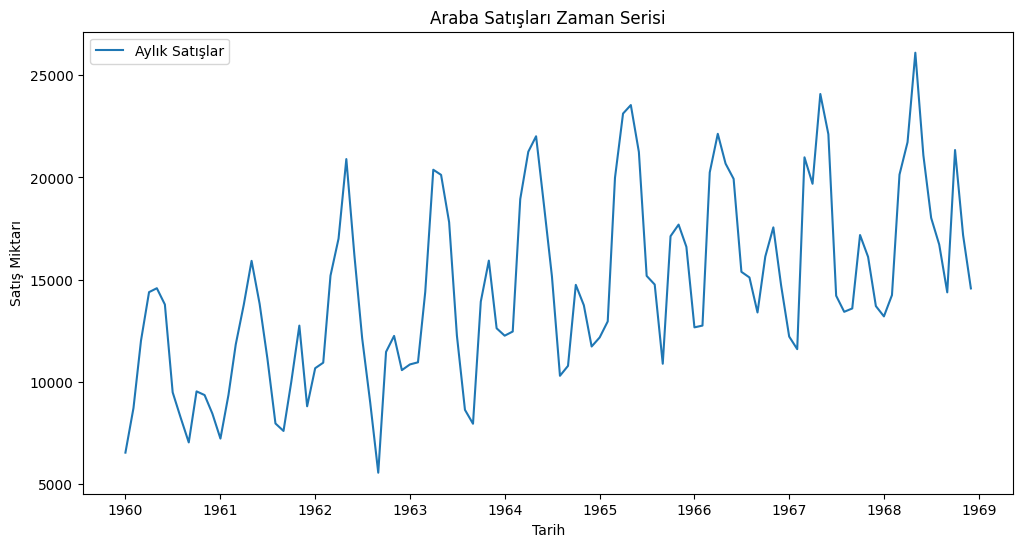

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Veriyi yükleyelim
df = pd.read_csv('monthly-car-sales.csv')

# 2. Tarih sütununu Python'ın anlayacağı 'datetime' formatına çevirelim
df['Month'] = pd.to_datetime(df['Month'])

# 3. Tarihi indeks (satır başlığı) yapalım - Zaman serilerinde bu çok önemlidir
df.set_index('Month', inplace=True)

# 4. Verinin genel grafiğini çizelim
plt.figure(figsize=(12, 6))
plt.plot(df, label='Aylık Satışlar')
plt.title('Araba Satışları Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Satış Miktarı')
plt.legend()
plt.show()

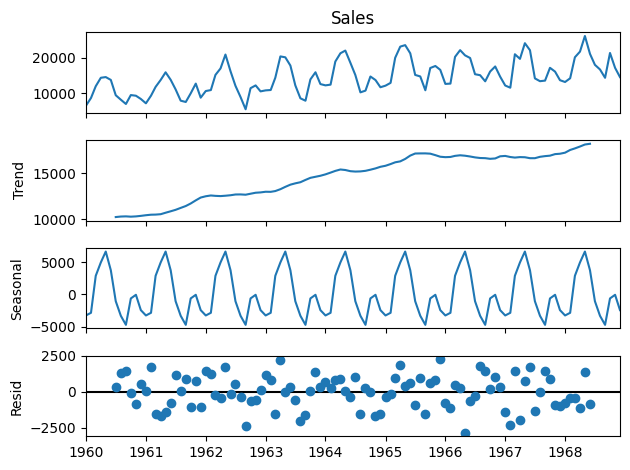

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Veriyi Trend, Mevsimsellik ve Artık (Gürültü) olarak ayıralım
# Veri aylık olduğu için period=12 kullanıyoruz
result = seasonal_decompose(df['Sales'], model='additive', period=12)

# Parçaları görselleştirelim
result.plot()
plt.show()

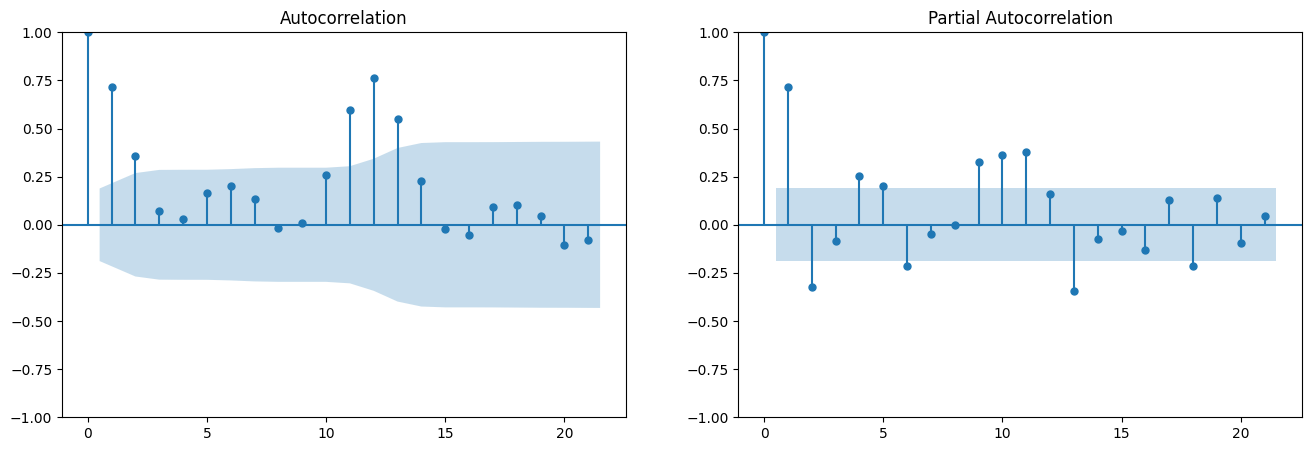

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['Sales'], ax=axes[0])
plot_pacf(df['Sales'], ax=axes[1])
plt.show()

C:\Users\bobto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bobto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


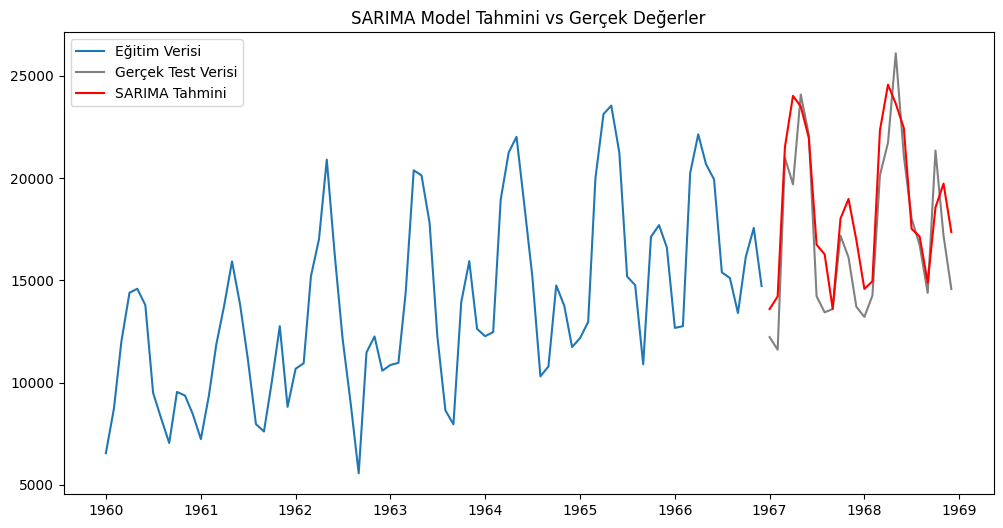

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Veriyi Eğitim ve Test olarak ayıralım (Son 24 ayı test yapalım)
train = df.iloc[:-24]
test = df.iloc[-24:]

# 2. SARIMA Modelini tanımlayalım
# order=(p,d,q) -> Trend parametreleri
# seasonal_order=(P,D,Q,s) -> Mevsimsel parametreler (s=12 aylık veri için)
model = SARIMAX(train['Sales'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))

# 3. Modeli eğitelim
model_fit = model.fit(disp=False)

# 4. Test süresi kadar tahmin yapalım
forecast = model_fit.get_forecast(steps=24)
y_pred = forecast.predicted_mean

# 5. Sonucu görselleştirelim
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Eğitim Verisi')
plt.plot(test.index, test['Sales'], label='Gerçek Test Verisi', color='gray')
plt.plot(test.index, y_pred, label='SARIMA Tahmini', color='red')
plt.title('SARIMA Model Tahmini vs Gerçek Değerler')
plt.legend()
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. RMSE Hesapla
rmse = np.sqrt(mean_squared_error(test['Sales'], y_pred))
print(f"SARIMA Modelinin RMSE Değeri: {rmse:.2f}")

# 2. Tahmin ve Gerçek Veriyi Bir Tabloda Karşılaştır
comparison_df = pd.DataFrame({'Gerçek': test['Sales'], 'Tahmin': y_pred})
print("\nSon 5 Ayın Karşılaştırması:")
print(comparison_df.tail())

SARIMA Modelinin RMSE Değeri: 2119.01

Son 5 Ayın Karşılaştırması:
            Gerçek        Tahmin
1968-08-01   16722  17135.968140
1968-09-01   14385  14890.639397
1968-10-01   21342  18562.574604
1968-11-01   17180  19729.473253
1968-12-01   14577  17359.274708


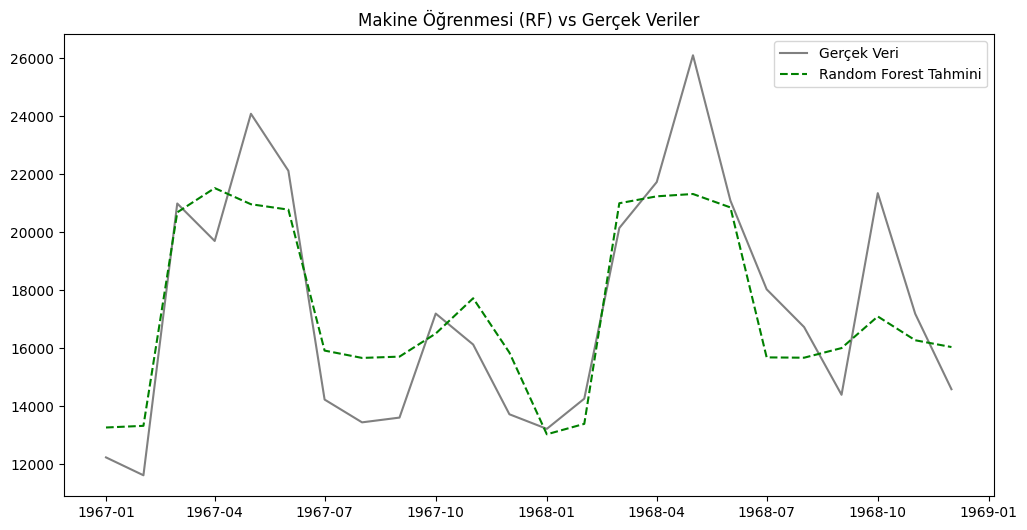

In [9]:
from sklearn.ensemble import RandomForestRegressor

# 1. Veriyi 'Gecikmeli' (Lag) hale getirelim (Öznitelik mühendisliği)
df_ml = df.copy()
for i in range(1, 13): # Son 12 ayı girdi olarak kullan
    df_ml[f'lag_{i}'] = df_ml['Sales'].shift(i)

df_ml.dropna(inplace=True) # Boş satırları temizle

# 2. X ve y değerlerini belirleyelim
X = df_ml.drop('Sales', axis=1)
y = df_ml['Sales']

# 3. Eğitim ve Test olarak ayıralım (Yine son 24 ay test olsun)
X_train, X_test = X.iloc[:-24], X.iloc[-24:]
y_train, y_test = y.iloc[:-24], y.iloc[-24:]

# 4. Random Forest modelini kuralım ve eğitelim
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Tahmin yapalım
rf_pred = rf_model.predict(X_test)

# 6. Sonuçları görselleştirelim
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Sales'], label='Gerçek Veri', color='gray')
plt.plot(test.index, rf_pred, label='Random Forest Tahmini', color='green', linestyle='--')
plt.title('Makine Öğrenmesi (RF) vs Gerçek Veriler')
plt.legend()
plt.show()

In [10]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore") # Gereksiz uyarıları gizleyelim

# 1. Parametre aralıklarını tanımlayalım (0, 1, 2 değerlerini deneyeceğiz)
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Grid Search başlatılıyor...')

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

# 2. Döngü ile tüm kombinasyonları deneyelim
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(df['Sales'],
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit(disp=False)
            
            # En düşük AIC değerini takip edelim
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f'En İyi SARIMA Modeli: {best_pdq} x {best_seasonal_pdq} - AIC:{best_aic}')

Grid Search başlatılıyor...
En İyi SARIMA Modeli: (0, 1, 1) x (0, 1, 1, 12) - AIC:1436.8942015080356


In [11]:
# 1. En iyi parametrelerle modelimizi tanımlayalım
best_model = SARIMAX(df['Sales'],
                     order=(0, 1, 1),
                     seasonal_order=(0, 1, 1, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

# 2. Modeli eğitelim
best_results = best_model.fit(disp=False)

# 3. Model özetini yazdıralım
print(best_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -715.447
Date:                            Tue, 10 Feb 2026   AIC                           1436.894
Time:                                    19:49:36   BIC                           1444.078
Sample:                                01-01-1960   HQIC                          1439.776
                                     - 12-01-1968                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8372      0.066    -12.691      0.000      -0.967      -0.708
ma.S.L12      -0.4687      0.114   

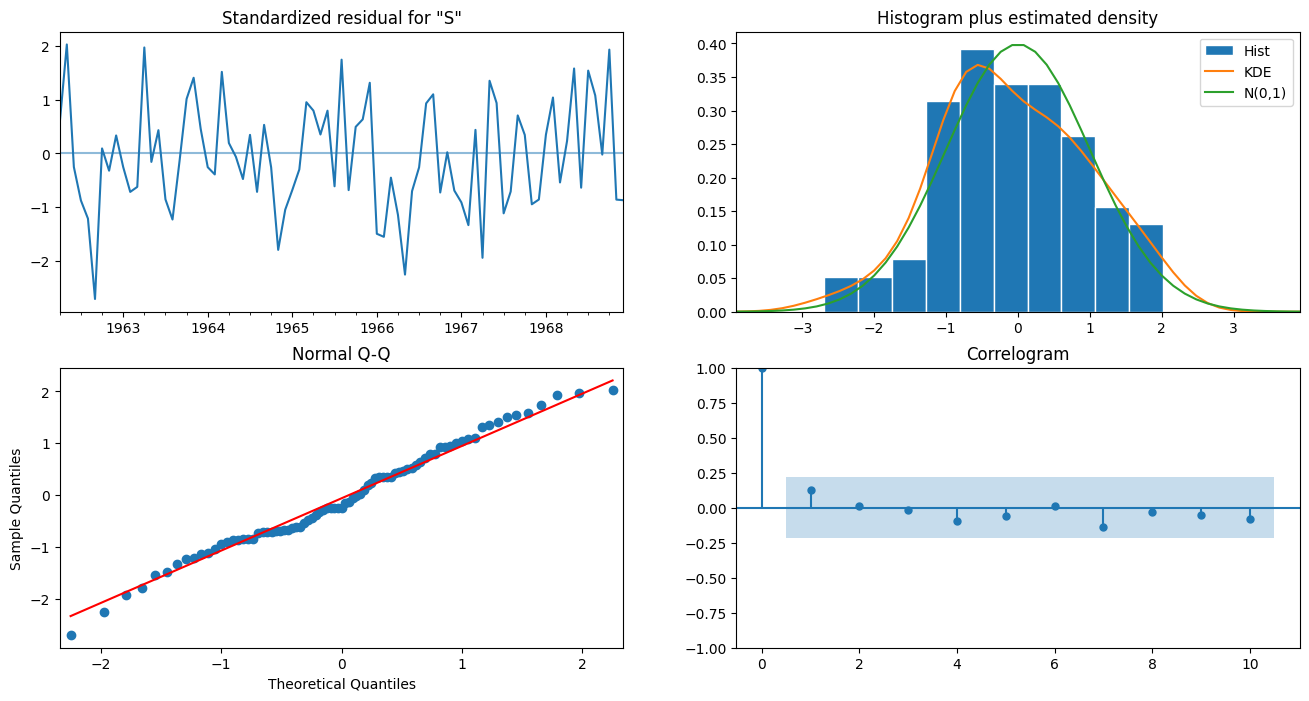

In [12]:
# Modelin tanılama grafiklerini çizdirelim
best_results.plot_diagnostics(figsize=(16, 8))
plt.show()

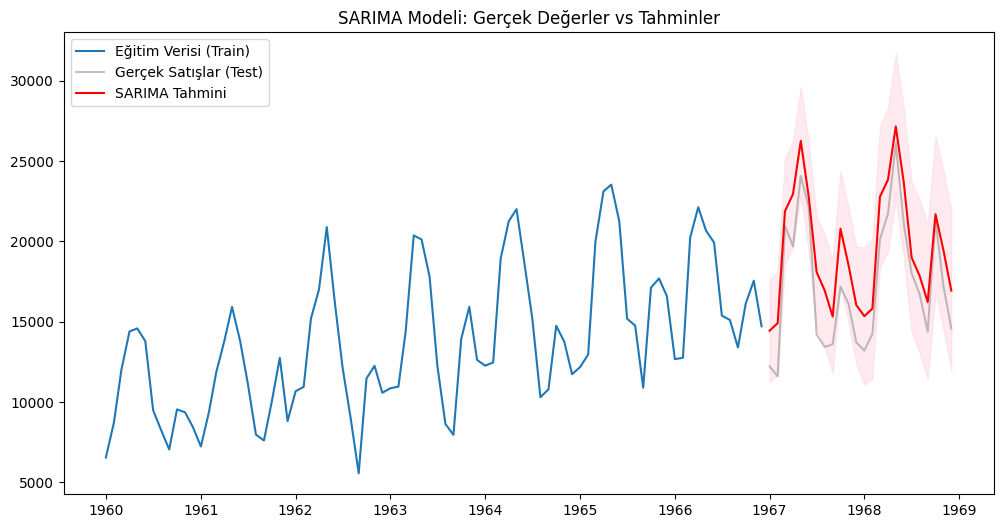

In [13]:
# 1. Tahmin Yapma
# Test setimizin uzunluğu kadar (24 ay) ileriye dönük tahmin yapıyoruz
forecast_object = best_results.get_forecast(steps=len(test))
y_pred = forecast_object.predicted_mean
conf_int = forecast_object.conf_int() # Güven aralığı (alt ve üst limitler)

# 2. Tahminleri Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Eğitim Verisi (Train)')
plt.plot(test.index, test['Sales'], label='Gerçek Satışlar (Test)', color='gray', alpha=0.5)
plt.plot(test.index, y_pred, label='SARIMA Tahmini', color='red')

# Güven aralığını grafiğe ekleyelim (Tahminin ne kadar esneme payı var?)
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA Modeli: Gerçek Değerler vs Tahminler')
plt.legend()
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE (Kök Ortalama Kare Hata) hesaplayalım
rmse = np.sqrt(mean_squared_error(test['Sales'], y_pred))
print(f"SARIMA Modelinin RMSE Değeri: {rmse:.2f}")

# Ortalama satış değerini görelim ki hatanın büyüklüğünü kıyaslayalım
print(f"Test Verisindeki Ortalama Satış: {test['Sales'].mean():.2f}")

SARIMA Modelinin RMSE Değeri: 2325.18
Test Verisindeki Ortalama Satış: 17404.75


Random Forest RMSE Değeri: 1976.07


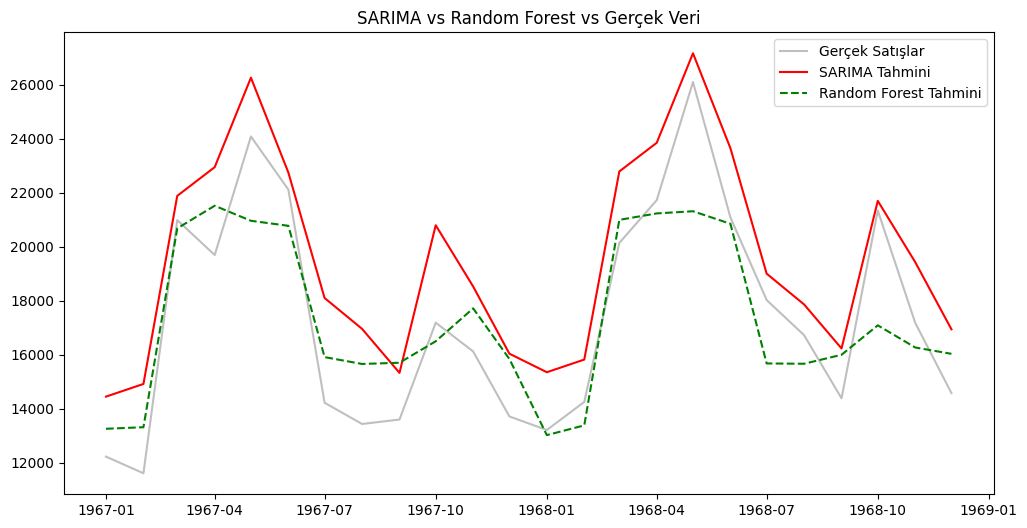

In [15]:
from sklearn.ensemble import RandomForestRegressor

# 1. Öznitelik Mühendisliği (Feature Engineering): Gecikmeli veriler oluşturalım
df_ml = df.copy()
for i in range(1, 13): # Son 12 ayı girdi olarak kullanıyoruz
    df_ml[f'lag_{i}'] = df_ml['Sales'].shift(i)

# NaN (boş) değerleri temizleyelim (İlk 12 ayın öncesi olmadığı için boş kalacaktır)
df_ml.dropna(inplace=True)

# 2. Veriyi Eğitim ve Test olarak ayıralım (SARIMA ile aynı bölme işlemini yapıyoruz)
X = df_ml.drop('Sales', axis=1) # Girdiler (Lags)
y = df_ml['Sales']            # Hedef (Satış)

X_train, X_test = X.iloc[:-24], X.iloc[-24:]
y_train, y_test = y.iloc[:-24], y.iloc[-24:]

# 3. Random Forest Modelini kuralım ve eğitelim
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Tahmin yapalım
rf_pred = rf_model.predict(X_test)

# 5. RMSE Hesaplayalım
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"Random Forest RMSE Değeri: {rf_rmse:.2f}")

# 6. Görsel Karşılaştırma
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Sales'], label='Gerçek Satışlar', color='gray', alpha=0.5)
plt.plot(test.index, y_pred, label='SARIMA Tahmini', color='red')
plt.plot(test.index, rf_pred, label='Random Forest Tahmini', color='green', linestyle='--')
plt.title('SARIMA vs Random Forest vs Gerçek Veri')
plt.legend()
plt.show()

In [18]:
# 1. Modeli SADECE train verisiyle eğitiyoruz 
best_model = SARIMAX(train['Sales'], 
                     order=(0, 1, 1), 
                     seasonal_order=(0, 1, 1, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

best_results = best_model.fit(disp=False)

# 2. Test seti uzunluğu kadar (24 ay) ileriye dönük tahmin yapıyoruz
forecast_obj = best_results.get_forecast(steps=len(test))
y_pred_sarima = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# 3. Tahminlerin tarih indeksini test verisiyle eşitleyelim (Garantiye almak için)
y_pred_sarima.index = test.index
conf_int.index = test.index

# 4. Karşılaştırma tablosunu tekrar oluşturalım
comparison_tab = pd.DataFrame({
    'Gerçek': test['Sales'],
    'Tahmin': y_pred_sarima,
    'Alt Limit': conf_int.iloc[:, 0],
    'Üst Limit': conf_int.iloc[:, 1]
})

print("Tahmin Sonuçları (Güncellendi):")
print(comparison_tab.head())


Tahmin Sonuçları (Güncellendi):
            Gerçek        Tahmin     Alt Limit     Üst Limit
Month                                                       
1967-01-01   12225  13898.078719  10765.890092  17030.267346
1967-02-01   11608  14209.414400  11060.369359  17358.459440
1967-03-01   20985  21076.381812  17910.581364  24242.182260
1967-04-01   19692  23537.468798  20354.999906  26719.937689
1967-05-01   24081  23048.129929  19849.078836  26247.181022
